# Homework 4
Brandon Hawkins

The goal of this assigment is to predict household poverty levels given individual and household information. We are going to try and approximate a household's poverty level based on factors such as education and the number of refrigerators in the house. 

To start I want to give credit to those that have helped me with this assignment. Listed below are the names of those who have helped.

Tyler Folkman - https://github.com/tfolkman <br>

Will Koehrsen - https://www.kaggle.com/willkoehrsen <br>

Conner Leavitt

The remainder of this notebook will follow the following structure. The end goal is to have a data set that will best predict a houshold's poverty level.

## Table of Contents

1) Analyze target <br>
2) Clean the data set <br>
3) Visualize the data <br>
4) Use machine learning models to predict results <br>
5) Discuss efectiveness of models <br>

Let's begin by importing the necessary packages to work through our analysis.

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

#don't see warnings
import warnings
warnings.filterwarnings('ignore')

Next, we will import our dataset. For the purpose of this homework assignment we will just download the training data set. If I were doing the Kaggle Competition I would have downloaded both the training and testing data and predicted the results of the testing data to submit, but since the deadline is past I will just be testing the models on their F1 scores.

In [2]:
#download training data set
train = pd.read_csv("/Users/brandonhawkins/Downloads/povertytrain.csv")

## 1) Analyze target

Our target variable measures the poverty level of the household. It is measured from a value 1-4. Kaggle describes the values listed below. <br>
1 = Extreme poverty <br>
2 = Moderate poverty <br>
3 = Vulnerable households <br> 
4 = Non-vulnerable households <br> 

This means that for purposes for this assignment we are interested in predicting which poverty level a household falls into.

Let's go ahead and look at the summary statistics for our target.

In [3]:
#defining target variable
target = train['Target']
target.describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

Looking at these statistics, we can see that there doesn't seem to be anything unusual about our data. All of our data falls between 1-4, which is what we expected. We can also see that our mean is around 3 which is described as a vulnerable household.

Let's look at how many households are represented by each poverty category to get and idea of how our data is spread.

In [4]:
#count frequency of each poverty count
target_counts = target.value_counts()
target_counts.head()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

Text(0.5,1,'Frequency of Poverty Levels in Dataset')

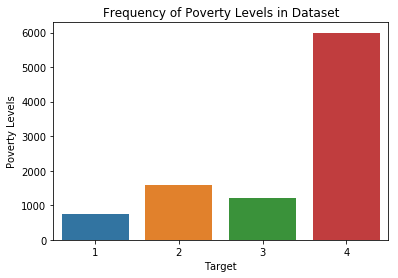

In [5]:
sns.countplot(x="Target", data=train)
plt.ylabel('Poverty Levels')
plt.title('Frequency of Poverty Levels in Dataset')

We can see from the data set that we have many more samples of data that are classified as non-vulnerable. This is a potential problem because the people we are likely more interested in are those in worse financial situations, but our data does not represent these groups very well. This is something important to keep in mind when analying our results.

# Clean the data set

We now want to take a loot at our data and see what we are dealing with to get it ready for modelling. This section will be divided into the following steps. <br>
1) Fix object data <br>
2) Fix missing data <br>

Let's start by looking at some basic information so we can get a good idea where to start.

In [6]:
#look at data
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## 1) Object Data

In [7]:
#look to see what type of data we have
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In looking at the types of data we have I noticed that we have 5 features that are classified as objects. This will cause a problem because they won't work well with our models. Let's go ahead and see what is included in this information to see if we can make it easier to work with.

In [8]:
#look at our object data
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The data description in the Kaggle documents helps us to better understand what each of these variables mean. Their definitions are listed below. <br>

Id = a unique identifier for each row <br>

idhogar = this is a unique identifier for each household <br>

dependency = Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64) <br>

edjefe = years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0 <br>

edjefa = years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0 <br>

We will end up dropping both our "Id" and "idhogar" features, but we will come back to that later. Let's first look at "dependency".

In [9]:
#determine value counts for dependency
train['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
1.3333334      84
.40000001      84
2.5            77
5              24
3.5            18
1.25           18
.80000001      18
2.25           13
.71428573      12
1.2            11
1.75           11
.22222222      11
.83333331      11
.2857143        9
1.6666666       8
.60000002       8
.16666667       7
6               7
Name: dependency, dtype: int64

Looking at it we can see that the only two objects are "yes" and "no" and that they consume a majority of the data for this variable. Although the description for this particular variable does not say that yes = 1 and no = 0 we can assume that this is the case for this feature. Looking at the value counts we notice that there are no "1's" or "0's" which makes our assumption more plausible. 

Let's go ahead and see if the same is true for our remaining two object features.

In [10]:
#determine unique values for edjefe
train['edjefe'].unique()

array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
       '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
      dtype=object)

In [11]:
#determine unique values for edjefa
train['edjefa'].unique()

array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
       '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
      dtype=object)

We can now see that for all three of these variables that we need to convert yes to 1 and no to 0. Let's go ahead and do that now.

In [12]:
#change to float and convert yes to 1 and no to 0
mapping = {"yes": 1, "no": 0}
train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['edjefa'] = train['edjefa'].replace(mapping).astype(np.float64)
train['edjefe'] = train['edjefe'].replace(mapping).astype(np.float64)

In [13]:
#make sure that we changed what we wanted
train[['dependency', 'edjefa', 'edjefe']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 3 columns):
dependency    9557 non-null float64
edjefa        9557 non-null float64
edjefe        9557 non-null float64
dtypes: float64(3)
memory usage: 224.1 KB


Awesome! We have now converted our objects to floats and fixed our data so that it will be easier to work with.

## 2) Missing variables

We now want to look and see if we have any missing data that we need to fix. Let's start by seeing what variables actually have missing information.

In [14]:
#see missing data
train.isnull().sum().sort_values(ascending=False)[:7]

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
techozinc            0
techoentrepiso       0
dtype: int64

It looks like we have 5 variables with missing data. Kaggle's definition for each variable is listed below. <br>

rez_esc = Years behind in school <br>

v18q1 = Number of tablets household owns <br>

v2a1 = Monthly rent payment <br>

meaneduc = Average years of education for adults (18+) <br>

SQBmeaned = Square of the mean years of education of adults (>=18) in the household <br>

Let's begin at looking at our "rez_esc" variable. In looking through the variable description we learn that this variable only identifies people behind in school that are in school. This would mean that missing variables simply mean that they are not in school and are therefor not behind in school. Let's go ahead and set this value to 0 for purposes of our predictions.

In [15]:
#fill in missing rez_esc with 0
train.loc[(train['rez_esc'].isnull()), 'rez_esc'] = 0

Now that we have that taken care of, let's look at "v18q1". This variable measures the number of tablets in the household. It is important to notice that another question on the survey asks if they have a tablet or not. This will help us when filling in the missing values.

In [16]:
#look at unique tablet values
train['v18q1'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

It looks like zero isn't a value in this data entry so it could be that households with 0 tablets are marked nan. Let's go ahead and change it to zero because these values align with the variable that asks if they have a tablet or not.  

In [17]:
#fill in missing tablet values with 0
train.loc[(train['v18q1'].isnull()), 'v18q1'] = 0

Let's move on to look at "v2a1". This measures the amount the household pays for monthly rent.

In [18]:
#look at unique tablet values
train['v2a1'].unique()

array([ 190000.,  135000.,      nan,  180000.,  130000.,  100000.,
         90000.,  215000.,  150000.,  120000.,   80000.,  168000.,
         40000.,  155000.,  200000.,  350000.,  270000.,  300000.,
        250000.,  260000.,  564834.,  175000.,   25310.,  400000.,
        450000.,  399378.,  119813.,  125518.,  125000.,   60000.,
         35000.,  160000.,  170000.,  500000.,  230000.,  185000.,
        220000.,  570540.,  342324.,       0.,  127000.,   52000.,
        240000.,  278000.,   70000.,  110000.,  100297.,  210000.,
        770229.,  285270.,  145000.,   96000.,  542013.,   65000.,
         85000.,  104000.,  275000.,  140000.,  280000.,  105661.,
         20000.,   16000.,   55000.,   30000.,  283000.,  245000.,
        191500.,  510000.,   36350.,   89000.,  600000.,   75000.,
         50000.,   84529.,  550000.,  132000.,  470000.,   27000.,
        176000.,  205000.,  380000.,  855810.,  427905.,  290975.,
        188000.,  118097.,  360000.,  325000., 1000000.,  7000

In looking at this information and the descriptions that Kaggle gave us we notice that there are many people who own their own houses and would not have a monthly payment. Let's set these missing values to zero too.

In [19]:
#fill in missing rent values with 0
train.loc[(train['v2a1'].isnull()), 'v2a1'] = 0

Since we don't have very many missing variables from "meaneduc" and "SQBmeaned" and they seem to be related to each other let's just drop these observations.

In [20]:
train = train.drop(['meaneduc', 'SQBmeaned'], axis = 1)

Now let's go ahead and drop our Id variables to get ready to feed our data into our models.

In [21]:
#drop Id variables
train = train.drop('Id', axis=1)
train = train.drop('idhogar', axis=1)

## Visualize Data

Now that we have cleaned our data let's look to see what it looks like.

Text(68.0938,0.5,'Highest Correlated Variables with Poverty Levels')

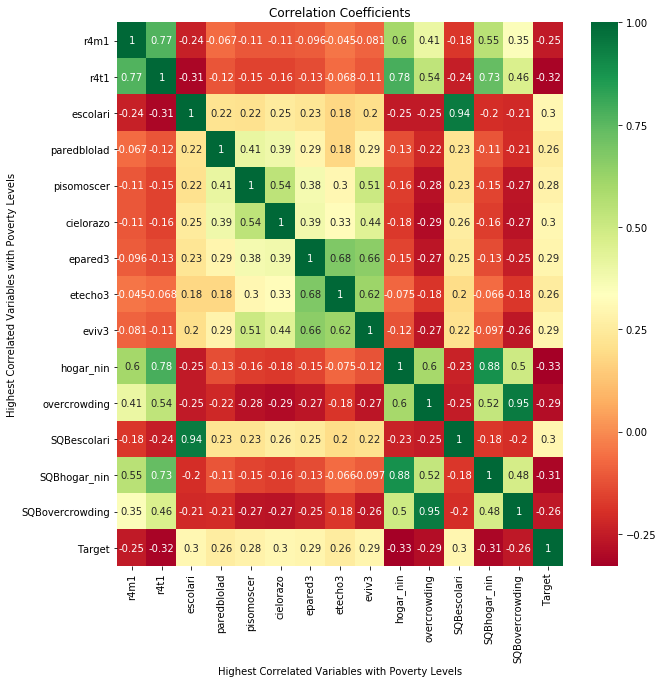

In [22]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["Target"])>0.25]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.title('Correlation Coefficients')
plt.xlabel('Highest Correlated Variables with Poverty Levels')
plt.ylabel('Highest Correlated Variables with Poverty Levels')

This graph helps us see what has the strongest relationship with Poverty Levels. Dark green or red squares are the variables that most correlate with our target and could potentially be the most predictive. Listed below are the most correlated variables, their correlation coefficient, and what they mean. Some of these variables are the transformed square root of the variable and I won't include these in this list. <br>

hogar_nin (-0.33) = Number of children 0 to 19 in household <br>

r4t1 (-0.32) = Persons younger than 12 years of age <br>

escolari (0.3) = Years of schooling <br>

overcrowding (-0.29) = Number persons per room <br>

epared3 (0.29) = Whether or not walls are good <br>

This helps to give us an idea of what features are most important in our data and better understand what is impacting poverty levels. We can see that more young children and having more people per room inside the house describe housholds with increased poverty, while households with more education and higher quality walls describe households with less poverty.

We'll also need to standardize our data before we begin running our models.

In [23]:
#Scale data
scaler = StandardScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

## 4) Models

To begin modelling we will split our data into a training and test data set. This will give us something to train our model on and something to test it on.

In [24]:
#split model
X_train, X_test, y_train, y_test = train_test_split(scaled_train, target, test_size=.33, random_state=42)

Now that we have our training and test data set let's try a few different models. The first one we will try is a logistic regression. We will run it through a basic logistical regression and report our f1 scores for the training and testing data set.

In [25]:
#logistic regression
logreg = linear_model.LogisticRegression()
y_predlog = logreg.fit(X_train, y_train).predict(X_test)

In [43]:
#f1 score for logistic regression
logreg_f1_train = f1_score(list(y_train), list(logreg.predict(X_train)), average='macro')
logreg_f1_test = f1_score(list(y_test), list(logreg.predict(X_test)), average='macro')
print(logreg_f1_train)
print(logreg_f1_test)

0.9096266393342858
0.8644870011943628


Not bad! We see that our testing data set had an f1 of 86%. This means that when taking the mean of both precision and recall results for our testing data set we report 86%. Because these numbers aren't too far off we aren't too concerned with overfitting.

Let's go ahead and now try Naive Bayes using a Gaussian distribution and random forest and see what our results are.

In [45]:
#Gaussian 
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [37]:
#f1 score for Gaussian
gnb_f1_train = f1_score(list(y_train), list(gnb.predict(X_train)), average='macro')
gnb_f1_test = f1_score(list(y_test), list(gnb.predict(X_test)), average='macro')
print(gnb_f1_train)
print(gnb_f1_test)

1.0
0.9979701923058106


In [29]:
#random forest
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)
param_grid = {"n_estimators":[90, 105, 110, 120, 140], "max_features": ['auto','log2']}
rfc_gridsearch = GridSearchCV(rfc,param_grid=param_grid ,cv=5)
rfc_gridsearch.fit(X_train,y_train)
y_predrfc = rfc.fit(X_train, y_train).predict(X_test)

In [30]:
#f1 score for random forest
rfc_f1_train = f1_score(list(y_train), list(rfc.predict(X_train)), average='macro')
rfc_f1 = f1_score(list(y_test), list(rfc.predict(X_test)), average='macro')
print(rfc_f1_train)
print(rfc_f1)

0.998156217936786
0.9320941594307378


In looking at our results we see that it appears that Naive Bayes performed better. It was 100% accurate on the training data set and 99.8% accurate on the test data set. Let's go ahead and evaluate this model and see what conclusions we can draw from it.

## 5) Analyze model

Let's begin by using a confusion matrix to determine the number of data points our Naive Bayes model got right.

In [47]:
#confusion matrix
confusion_matrix(y_test, y_pred_gnb)

array([[ 262,    2,    0,    0],
       [   0,  524,    0,    0],
       [   0,    0,  422,    0],
       [   0,    2,    0, 1942]])

The numbers on the diagonal are the ones that we predicted correctly and the off diagonals are the ones we predicted incorrectly. It looks like we did pretty good and weren't off very often. Also we were only off on one of our columns meaning that our wrong predictions were only located in one poverty category.

As we can see that although it isn't perfect our Naive Bayes model did a pretty good job at predicting our poverty levels. If I were entering this into a competition I would then predict the results on the provided test data set and submit them, but all we have to go off of is our f1 scores.

The end.